In [52]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("gopalbhattrai/pascal-voc-2012-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1


In [53]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [54]:
import xml.etree.ElementTree as ET

tree = ET.parse('/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/Annotations/2007_000027.xml')
root = tree.getroot()

for obj in root.findall('object'):
    cls = obj.find('name').text
    bndbox = obj.find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    print(cls, xmin, ymin, xmax, ymax)

    # Optional: parse parts if needed
    for part in obj.findall('part'):
        part_name = part.find('name').text
        part_box = part.find('bndbox')
        pxmin = int(part_box.find('xmin').text)
        pymin = int(part_box.find('ymin').text)
        pxmax = int(part_box.find('xmax').text)
        pymax = int(part_box.find('ymax').text)
        print('   Part:', part_name, pxmin, pymin, pxmax, pymax)


person 174 101 349 351
   Part: head 169 104 209 146
   Part: hand 278 210 297 233
   Part: foot 273 333 297 354
   Part: foot 319 307 340 326


In [55]:
class_names = ['__background__', 'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
    'dog', 'horse', 'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor'
]
name_to_ix = {k: i-1 for i, k in enumerate(class_names) if k != '__background__'}

In [56]:
def yolo_loss(y_true, y_pred):
    # Ground truth split
    obj_true = tf.expand_dims(y_true[..., 0], -1)   # (B,18,18,1)
    bbox_true = y_true[..., 1:5]                    # (B,18,18,4)
    cls_true  = y_true[..., 5:]                     # (B,18,18,C)

    # Predictions split
    obj_pred  = y_pred[..., 0:1]                    # (B,18,18,1)
    bbox_pred = y_pred[..., 1:5]                    # (B,18,18,4)
    cls_pred  = y_pred[..., 5:]                     # (B,18,18,C)

    pos_weight = 5.0

    # --- Objectness loss ---
    bce = tf.keras.losses.BinaryCrossentropy(reduction="none")
    obj_raw_loss = bce(obj_true, obj_pred)          # (B,18,18)
    obj_raw_loss = tf.expand_dims(obj_raw_loss, -1) # -> (B,18,18,1)
    obj_loss = tf.reduce_mean(
        obj_raw_loss * (1 + (pos_weight - 1) * obj_true)
    )

    # --- Bbox regression loss (mask by obj_true) ---
    bbox_loss = tf.reduce_mean(tf.square(bbox_true - bbox_pred) * obj_true)

    # --- Class loss (mask by obj_true) ---
    cce = tf.keras.losses.CategoricalCrossentropy(reduction="none")
    cls_raw_loss = cce(cls_true, cls_pred)          # (B,18,18)
    cls_raw_loss = tf.expand_dims(cls_raw_loss, -1) # -> (B,18,18,1)
    cls_loss = tf.reduce_mean(cls_raw_loss * obj_true)

    return obj_loss + bbox_loss + cls_loss


In [57]:
with open('/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/ImageSets/Main/train.txt','r') as f:
    reader = f.read()
train_arr = reader.split('\n')
train_arr = [x for x in train_arr if x!='']

train_dataset = tf.data.Dataset.from_tensor_slices(train_arr)
with open('/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/ImageSets/Main/val.txt','r') as f:
    reader = f.read()
val_arr = reader.split('\n')
val_dataset = tf.data.Dataset.from_tensor_slices(val_arr)

In [58]:

img_dir = '/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/JPEGImages'
ann_dir = '/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/Annotations'

import xml.etree.ElementTree as ET
def preprocess_ds(x,img_dir , ann_dir , grid_size = 18):
    img_path = tf.strings.join([img_dir, "/", x, ".jpg"])
    xml_path = tf.strings.join([ann_dir, "/", x, ".xml"])
    
    def _xmlparser(xml_path_str):
            xml_path_str = xml_path_str.numpy().decode()  # convert bytes to str
            num_classes = len(class_names)-1

            try:
                tree = ET.parse(xml_path_str)
                root = tree.getroot()
                dims = []
                for x in root.find('size'):
                    dims.append(int(x.text))

                width , height , channels = dims
                objects_array = []
                for x in root.findall('object'):
                    objects_array.append(x)
                
                # An array to store all the bounding box coordinates for every image in the image
                
                name_arr = []
                bndbox_array = []

                for x in objects_array:
                    # Bounding box logic
                    temp_arr = []
                    for y in x.find('bndbox'):
                        temp_arr.append(int(y.text))
                    bndbox_array.append(temp_arr)
                    name_arr.append(x.find('name').text)    


                index_arr = [name_to_ix[name] for name in name_arr]



                default_y_label = [0] + [0]*4 + [0]*num_classes

                y_label_arr = np.zeros((grid_size, grid_size, len(default_y_label)), dtype='float')

                # Initialize each cell with the default label
                for i in range(grid_size):
                    for j in range(grid_size):
                        y_label_arr[i][j] = default_y_label.copy()

                def label_array():
                    y = np.zeros((grid_size, grid_size, 5 + num_classes), dtype=np.float32)
                    S = grid_size
                    for i, (xmin, ymin, xmax, ymax) in enumerate(bndbox_array):
                        # pad/resize math
                        scale = min(448/width, 448/height)
                        new_w, new_h = width*scale, height*scale
                        pad_x, pad_y = (448 - new_w)/2.0, (448 - new_h)/2.0

                        # absolute coords in padded image space
                        cx_abs = ((xmin + xmax)/2.0)*scale + pad_x
                        cy_abs = ((ymin + ymax)/2.0)*scale + pad_y
                        bw_abs = (xmax - xmin)*scale
                        bh_abs = (ymax - ymin)*scale

                        # normalize to 448 and cast
                        cx = np.float32(cx_abs / 448.0)
                        cy = np.float32(cy_abs / 448.0)
                        bw = np.float32(bw_abs / 448.0)
                        bh = np.float32(bh_abs / 448.0)

                        # clamp to [0,1]
                        cx = np.clip(cx, 0.0, 1.0)
                        cy = np.clip(cy, 0.0, 1.0)
                        bw = np.clip(bw, 0.0, 1.0)
                        bh = np.clip(bh, 0.0, 1.0)

                        # pick cell from (cx, cy)
                        col = min(int(cx * S), S-1)
                        row = min(int(cy * S), S-1)

                        if y[row, col, 0] == 0:  # simple policy: first box wins
                            onehot = np.zeros(num_classes, dtype=np.float32)
                            onehot[index_arr[i]] = 1.0
                            y[row, col, :5] = [1.0, cx, cy, bw, bh]
                            y[row, col, 5:] = onehot
                    return y.astype(np.float32)
            except Exception as e:
                print("XML ERR:", xml_path_str.numpy().decode(), repr(e))
                return np.zeros((grid_size, grid_size, 5 + num_classes), dtype=np.float32)
            y_true = label_array()

            


            return y_true
    
    num_classes = len(class_names)-1
    y_label = tf.py_function(func=_xmlparser, inp=[xml_path], Tout=tf.float32)
    y_label.set_shape([grid_size, grid_size, 5 + num_classes])
    # Load and preprocess image
    img_raw = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img = tf.image.resize_with_pad(img, 448, 448)
    img = tf.cast(img, tf.float32) / 255.0

    return img , y_label

for x in train_dataset.map(lambda x :preprocess_ds(x,img_dir,ann_dir)).take(1):
    print(x[1])

tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]

In [59]:
img_dir = '/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/JPEGImages'
ann_dir = '/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/Annotations'
# for x in train_dataset.map(lambda x:preprocess(x,img_dir,ann_dir)).take(1):
#     print(x)

In [60]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D, Activation, Concatenate, Lambda
from tensorflow.keras.models import Model

def TinyYOLO_Light(input_shape=(448, 448, 3), num_classes=None, grid_size=18):
    if num_classes is None:
        raise ValueError("Pass num_classes explicitly (e.g., len(class_names)).")

    inputs = Input(shape=input_shape)

    # 448 -> 224
    x = Conv2D(32, 3, padding='same')(inputs); x = BatchNormalization()(x); x = LeakyReLU(0.1)(x)
    x = MaxPooling2D(2)(x)

    # 224 -> 112
    x = Conv2D(64, 3, padding='same')(x); x = BatchNormalization()(x); x = LeakyReLU(0.1)(x)
    x = MaxPooling2D(2)(x)

    # 112 -> 56
    x = Conv2D(128, 3, padding='same')(x); x = BatchNormalization()(x); x = LeakyReLU(0.1)(x)
    x = MaxPooling2D(2)(x)

    # 56 -> 28
    x = Conv2D(256, 3, padding='same')(x); x = BatchNormalization()(x); x = LeakyReLU(0.1)(x)
    x = MaxPooling2D(2)(x)

    # keep 28x28
    x = Conv2D(512, 3, padding='same')(x); x = BatchNormalization()(x); x = LeakyReLU(0.1)(x)
    x = Conv2D(1024, 3, padding='same')(x); x = BatchNormalization()(x); x = LeakyReLU(0.1)(x)
    x = Conv2D(1024, 3, padding='same')(x); x = BatchNormalization()(x); x = LeakyReLU(0.1)(x)

    # 28 -> 18 with valid 11x11 conv; channels = 5 + C
    pred_raw = Conv2D(5 + num_classes, 11, padding='valid', name='pred_raw')(x)  # (None, 18, 18, 5+C)

    # Split head: [obj | bbox(4) | class(C)]
    obj  = Lambda(lambda t: t[..., 0:1], name='obj')(pred_raw)
    bbox = Lambda(lambda t: t[..., 1:5], name='bbox')(pred_raw)
    cls  = Lambda(lambda t: t[..., 5:],  name='cls')(pred_raw)

    # Activations
    obj  = Activation('sigmoid', name='obj_sigmoid')(obj)       # [0,1]
    bbox = Lambda(lambda t: t[..., 1:5], name='bbox')(pred_raw)  # no sigmoid
    # [0,1] since your labels are normalized
    cls  = Activation('softmax', name='cls_softmax')(cls)       # single-label per cell

    outputs = Concatenate(axis=-1, name='yolo_out')([obj, bbox, cls])  # (None, 18, 18, 5+C)
    return Model(inputs, outputs)
model = TinyYOLO_Light(num_classes=len(class_names)-1)

In [61]:
def iou_metric(y_true, y_pred):
    # Shapes: (B, S, S, *)
    obj_true = y_true[..., 0]                                # (B,S,S)
    obj_mask = tf.cast(obj_true > 0.5, tf.float32)           # (B,S,S)

    bbox_true = y_true[..., 1:5]                             # (B,S,S,4) [xmin,ymin,xmax,ymax] normalized
    bbox_pred = y_pred[..., 1:5]                             # (B,S,S,4)

    # Intersection
    xmin_inter = tf.maximum(bbox_true[..., 0], bbox_pred[..., 0])
    ymin_inter = tf.maximum(bbox_true[..., 1], bbox_pred[..., 1])
    xmax_inter = tf.minimum(bbox_true[..., 2], bbox_pred[..., 2])
    ymax_inter = tf.minimum(bbox_true[..., 3], bbox_pred[..., 3])

    inter_w = tf.maximum(0.0, xmax_inter - xmin_inter)
    inter_h = tf.maximum(0.0, ymax_inter - ymin_inter)
    inter = inter_w * inter_h

    area_true = tf.maximum(0.0, (bbox_true[..., 2] - bbox_true[..., 0])) * tf.maximum(0.0, (bbox_true[..., 3] - bbox_true[..., 1]))
    area_pred = tf.maximum(0.0, (bbox_pred[..., 2] - bbox_pred[..., 0])) * tf.maximum(0.0, (bbox_pred[..., 3] - bbox_pred[..., 1]))
    union = area_true + area_pred - inter

    iou = inter / (union + 1e-7)                              # (B,S,S)
    # average only over positives
    pos = tf.reduce_sum(obj_mask)
    mean_iou = tf.cond(pos > 0, lambda: tf.reduce_sum(iou * obj_mask) / pos, lambda: 0.0)
    return mean_iou


In [ ]:
train_dataset_x = train_dataset.map(lambda x:preprocess_ds(x,img_dir,ann_dir)).batch(5).prefetch(tf.data.AUTOTUNE)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=yolo_loss, metrics=[iou_metric])

model.fit(train_dataset_x , epochs = 10)

Epoch 1/10


In [ ]:
for imgs, labels in train_dataset_x.take(1):
    print("Positives per image:", tf.reduce_sum(labels[...,0], axis=[1,2]))


Positives per image: tf.Tensor([2. 2. 3. 5. 2.], shape=(5,), dtype=float32)


2025-09-20 00:26:20.153089: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# MAJOR ISSUE 2: Your inference code is wrong for grid predictions
def correct_inference_visualization(model, image_path):
    """Correctly process YOLO grid output"""
    # Load and preprocess
    img_raw = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img_processed = tf.image.resize_with_pad(img, 448, 448)
    img_processed = tf.cast(img_processed, tf.float32) / 255.0
    img_batch = tf.expand_dims(img_processed, axis=0)
    
    # Get prediction - shape (1, 18, 18, 25)
    pred_grid = model.predict(img_batch, verbose=0)[0]  # Shape: (18, 18, 25)
    
    print(f"Prediction shape: {pred_grid.shape}")
    print(f"Objectness range: {pred_grid[...,0].min():.3f} to {pred_grid[...,0].max():.3f}")
    print(f"Class predictions range: {pred_grid[...,5:].min():.3f} to {pred_grid[...,5:].max():.3f}")
    
    # Find cells with highest objectness
    obj_scores = pred_grid[...,0]
    max_obj_idx = np.unravel_index(np.argmax(obj_scores), obj_scores.shape)
    print(f"Max objectness: {obj_scores[max_obj_idx]:.3f} at cell {max_obj_idx}")
    
    # Process only cells above threshold
    detections = []
    grid_size = 18
    
    for i in range(grid_size):
        for j in range(grid_size):
            cell_pred = pred_grid[i, j]
            objectness = cell_pred[0]
            
            if objectness > 0.1:  # Lower threshold for debugging
                print(f"Cell [{i},{j}]: obj={objectness:.3f}")
                
                # Get class prediction
                class_probs = cell_pred[5:]
                class_id = np.argmax(class_probs)
                class_conf = class_probs[class_id]
                
                # Ensure class_id is in valid range
                if 0 <= class_id < 20:  # Valid class range
                    bbox = cell_pred[1:5]
                    print(f"  Class: {class_id}, conf: {class_conf:.3f}")
                    print(f"  Bbox: {bbox}")
                    
                    detections.append({
                        'cell': (i, j),
                        'objectness': objectness,
                        'class_id': int(class_id),
                        'class_conf': class_conf,
                        'bbox': bbox
                    })
    
    print(f"Found {len(detections)} valid detections")
    return detections

# MAJOR ISSUE 3: Check your data preprocessing
def debug_data_preprocessing(train_dataset_x):
    """Debug what your data looks like"""
    for batch in train_dataset_x.take(1):
        images, labels = batch
        print(f"Batch shapes - Images: {images.shape}, Labels: {labels.shape}")
        
        # Check label statistics
        obj_mask = labels[...,0] > 0.5
        print(f"Objects per image: {tf.reduce_sum(tf.cast(obj_mask, tf.float32), axis=[1,2])}")
        print(f"Total positive cells in batch: {tf.reduce_sum(tf.cast(obj_mask, tf.float32))}")
        
        # Check class distribution
        positive_cells = labels[obj_mask]
        if len(positive_cells) > 0:
            classes = tf.argmax(positive_cells[:,5:], axis=1)
            print(f"Classes in positive cells: {tf.unique(classes)[0].numpy()}")
        else:
            print("No positive cells found!")
        
        # Check bbox values
        bbox_vals = labels[obj_mask][:,1:5]
        if len(bbox_vals) > 0:
            print(f"Bbox ranges: x={bbox_vals[:,0].numpy().min():.3f}-{bbox_vals[:,0].numpy().max():.3f}")
            print(f"             y={bbox_vals[:,1].numpy().min():.3f}-{bbox_vals[:,1].numpy().max():.3f}")


In [ ]:
pred = model.predict(train_dataset_x.take(1))
correct_inference_visualization(model,"/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/JPEGImages/2008_000008.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Prediction shape: (18, 18, 25)
Objectness range: 0.000 to 0.608
Class predictions range: 0.000 to 1.000
Max objectness: 0.608 at cell (np.int64(4), np.int64(4))
Cell [1,4]: obj=0.151
  Class: 0, conf: 0.520
  Bbox: [-0.17279938  0.7439492   0.35731384  0.18925592]
Cell [2,2]: obj=0.106
  Class: 14, conf: 0.494
  Bbox: [-0.42948285  0.57501864  0.5630387   0.22818002]
Cell [2,3]: obj=0.168
  Class: 14, conf: 0.428
  Bbox: [-0.36618474  0.67441916  0.59835535  0.3484849 ]
Cell [2,4]: obj=0.287
  Class: 14, conf: 0.337
  Bbox: [-0.18970278  0.67311454  0.51290625  0.47917774]
Cell [2,5]: obj=0.152
  Class: 14, conf: 0.337
  Bbox: [-0.16085961  0.5326333   0.50466067  0.48813495]
Cell [3,2]: obj=0.238
  Class: 14, conf: 0.616
  Bbox: [-0.4715999   0.3610852   0.73610324  0.37013993]
Cell [3,3]: obj=0.360
  Class: 14, conf: 0.582
  Bbox: [-0.3631762   0.3705347   0.7960375   0.47526297]
Cell [3,4]: obj=0.458
  Class: 14, conf: 0.452
  Bbox: [-0.1504632

[{'cell': (1, 4),
  'objectness': np.float32(0.15085238),
  'class_id': 0,
  'class_conf': np.float32(0.519891),
  'bbox': array([-0.17279938,  0.7439492 ,  0.35731384,  0.18925592], dtype=float32)},
 {'cell': (2, 2),
  'objectness': np.float32(0.105853334),
  'class_id': 14,
  'class_conf': np.float32(0.49421623),
  'bbox': array([-0.42948285,  0.57501864,  0.5630387 ,  0.22818002], dtype=float32)},
 {'cell': (2, 3),
  'objectness': np.float32(0.16815586),
  'class_id': 14,
  'class_conf': np.float32(0.42787805),
  'bbox': array([-0.36618474,  0.67441916,  0.59835535,  0.3484849 ], dtype=float32)},
 {'cell': (2, 4),
  'objectness': np.float32(0.28719318),
  'class_id': 14,
  'class_conf': np.float32(0.33712873),
  'bbox': array([-0.18970278,  0.67311454,  0.51290625,  0.47917774], dtype=float32)},
 {'cell': (2, 5),
  'objectness': np.float32(0.15243006),
  'class_id': 14,
  'class_conf': np.float32(0.3372258),
  'bbox': array([-0.16085961,  0.5326333 ,  0.50466067,  0.48813495], dtype

Found 39 detections
Detection 0: conf=0.101, class=2
Detection 1: conf=0.102, class=2
Detection 2: conf=0.120, class=2
Detection 3: conf=0.138, class=2
Detection 4: conf=0.168, class=2
Detection 5: conf=0.216, class=2
Detection 6: conf=0.195, class=2
Detection 7: conf=0.176, class=2
Detection 8: conf=0.149, class=2
Detection 9: conf=0.146, class=6
Detection 10: conf=0.155, class=6
Detection 11: conf=0.141, class=14
Detection 12: conf=0.107, class=14
Detection 13: conf=0.104, class=2
Detection 14: conf=0.130, class=2
Detection 15: conf=0.108, class=2
Detection 16: conf=0.122, class=2
Detection 17: conf=0.178, class=2
Detection 18: conf=0.200, class=2
Detection 19: conf=0.226, class=2
Detection 20: conf=0.198, class=14
Detection 21: conf=0.183, class=14
Detection 22: conf=0.175, class=14
Detection 23: conf=0.167, class=14
Detection 24: conf=0.104, class=2
Detection 25: conf=0.168, class=2
Detection 26: conf=0.172, class=2
Detection 27: conf=0.182, class=2
Detection 28: conf=0.148, class=

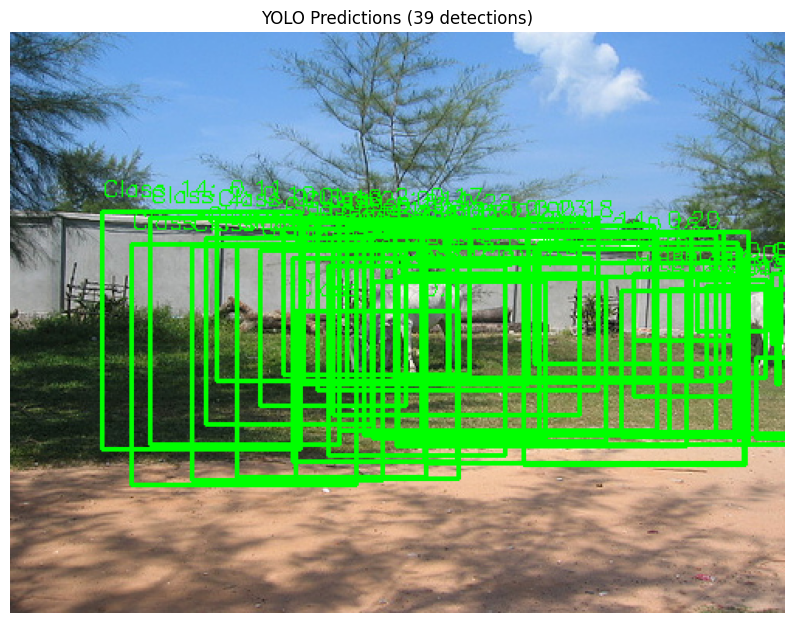

array([[[ 4.1418301e-04, -2.5581512e-01,  7.9793054e-01, ...,
          4.7265639e-05,  5.4314722e-08,  5.8814598e-04],
        [ 2.9983188e-03, -3.7143937e-01,  6.7963201e-01, ...,
          1.2612193e-03,  2.4672689e-05,  2.4612302e-02],
        [ 5.7824664e-03, -2.8738394e-01,  6.7935479e-01, ...,
          1.4849496e-03,  4.3360933e-04,  4.7455013e-02],
        ...,
        [ 8.1994850e-03,  6.6210943e-01,  3.4287697e-01, ...,
          1.2689047e-02,  3.4481522e-03,  5.6684151e-02],
        [ 5.9701540e-03,  6.8956697e-01,  2.4173273e-01, ...,
          9.4153108e-03,  5.4113856e-03,  8.8603809e-02],
        [ 1.3578969e-02,  6.5234804e-01,  3.0931979e-01, ...,
          1.2588658e-02,  1.4558186e-02,  3.2851592e-02]],

       [[ 2.5874635e-03, -3.8801363e-01,  9.5641708e-01, ...,
          2.2341957e-05,  1.4425003e-06,  3.9910255e-03],
        [ 2.4741920e-02, -5.3074718e-01,  7.4530387e-01, ...,
          2.0935487e-04,  1.5141808e-04,  3.8981576e-02],
        [ 7.3466830e-02, 

In [ ]:
import cv2
pred[0]
image = cv2.imread("/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/JPEGImages/2008_000008.jpg")
# Fix 3: For inference, you need to process the grid output
def process_yolo_output(prediction, confidence_threshold=0.5):
    """
    Process YOLO grid output to extract detections
    prediction shape: (18, 18, 25)
    """
    detections = []
    grid_size = prediction.shape[0]  # 18
    
    for i in range(grid_size):
        for j in range(grid_size):
            cell_pred = prediction[i, j]
            objectness = cell_pred[0]
            
            if objectness > confidence_threshold:
                bbox = cell_pred[1:5]  # cx, cy, w, h (normalized)
                class_probs = cell_pred[5:]
                class_id = np.argmax(class_probs)
                class_conf = class_probs[class_id]
                
                # Convert cell coordinates to image coordinates
                cx = (j + bbox[0]) / grid_size  # Add cell offset
                cy = (i + bbox[1]) / grid_size  # Add cell offset
                w = bbox[2]
                h = bbox[3]
                
                # Convert to corner coordinates
                xmin = cx - w/2
                ymin = cy - h/2
                xmax = cx + w/2
                ymax = cy + h/2
                
                detections.append({
                    'bbox': [xmin, ymin, xmax, ymax],
                    'confidence': objectness,
                    'class_id': class_id,
                    'class_confidence': class_conf
                })
    
    return detections

# Fix 4: Updated prediction visualization
def visualize_prediction(model, image_path):
    """Properly visualize YOLO predictions"""
    # Load and preprocess image
    img_raw = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    original_shape = tf.shape(img)[:2]
    
    img_processed = tf.image.resize_with_pad(img, 448, 448)
    img_processed = tf.cast(img_processed, tf.float32) / 255.0
    img_batch = tf.expand_dims(img_processed, axis=0)
    
    # Get prediction
    pred = model.predict(img_batch, verbose=0)[0]  # Shape: (18, 18, 25)
    
    # Process predictions
    detections = process_yolo_output(pred, confidence_threshold=0.1)
    
    print(f"Found {len(detections)} detections")
    for i, det in enumerate(detections):
        print(f"Detection {i}: conf={det['confidence']:.3f}, class={det['class_id']}")
    
    # Visualize if detections found
    if detections:
        import cv2
        image = cv2.imread(image_path)
        H, W = image.shape[:2]
        
        for det in detections:
            bbox = det['bbox']
            # Convert normalized to pixel coordinates
            x1, y1, x2, y2 = [int(coord * dim) for coord, dim in 
                             zip(bbox, [W, H, W, H])]
            
            # Draw bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Add label
            label = f"Class {det['class_id']}: {det['confidence']:.2f}"
            cv2.putText(image, label, (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        
        # Convert BGR to RGB for display
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 8))
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.title(f'YOLO Predictions ({len(detections)} detections)')
        plt.show()
    else:
        print("No detections above threshold")
visualize_prediction(model,"/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/JPEGImages/2008_000009.jpg")
pred[0]

In [ ]:
# Label mapping (from your notebook)
id_to_label_map = {
    0: "background", 1: "aeroplane", 2: "bicycle", 3: "bird", 4: "boat",
    5: "bottle", 6: "bus", 7: "car", 8: "cat",
    9: "chair", 10: "cow", 11: "diningtable", 12: "dog",
    13: "horse", 14: "motorbike", 15: "person", 16: "pottedplant",
    17: "sheep", 18: "sofa", 19: "train", 20: "tvmonitor"
}

def preprocess_image(image_path):
    """Preprocess a single image for inference"""
    img_raw = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    original_shape = tf.shape(img)[:2]  # H, W
    
    # Resize with padding (same as training)
    img = tf.image.resize_with_pad(img, 448, 448)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    
    return img, original_shape

def get_ground_truth_bbox(xml_path):
    """Extract ground truth bounding box from XML annotation"""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Get image dimensions
    size = root.find('size')
    W = int(size.find('width').text)
    H = int(size.find('height').text)
    
    # Get first object (following your training approach)
    obj = root.find('object')
    if obj is not None:
        cls = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        return [xmin, ymin, xmax, ymax], cls, (W, H)
    return None, None, (W, H)

def denormalize_bbox(norm_bbox, original_shape):
    """Convert normalized bbox back to pixel coordinates"""
    H, W = original_shape[0], original_shape[1]
    xmin, ymin, xmax, ymax = norm_bbox
    
    # Denormalize
    xmin_pixel = int(xmin * W)
    ymin_pixel = int(ymin * H)
    xmax_pixel = int(xmax * W)
    ymax_pixel = int(ymax * H)
    
    return [xmin_pixel, ymin_pixel, xmax_pixel, ymax_pixel]

def inference_with_visualization(model, image_path, xml_path=None, confidence_threshold=0.5):
    """Run inference and visualize results"""
    
    # Preprocess image
    processed_img, original_shape = preprocess_image(image_path)
    
    # Run prediction
    prediction = model.predict(processed_img, verbose=0)[0]  # Get first (and only) prediction
    
    # Parse prediction
    objectness = prediction[0]
    bbox_norm = prediction[1:5]  # normalized coordinates
    class_probs = prediction[5:]
    predicted_class_id = np.argmax(class_probs)
    predicted_class_name = id_to_label_map[predicted_class_id]
    max_class_prob = np.max(class_probs)
    
    print(f"Objectness: {objectness:.3f}")
    print(f"Predicted class: {predicted_class_name} (confidence: {max_class_prob:.3f})")
    print(f"Normalized bbox: [{bbox_norm[0]:.3f}, {bbox_norm[1]:.3f}, {bbox_norm[2]:.3f}, {bbox_norm[3]:.3f}]")
    
    # Load original image
    original_img = cv2.imread(image_path)
    H, W = original_img.shape[:2]
    
    # Create visualization
    fig, axes = plt.subplots(1, 2 if xml_path else 1, figsize=(15, 7))
    if xml_path:
        axes = [axes[0], axes[1]] if hasattr(axes, '__len__') else [axes, None]
    else:
        axes = [axes]
    
    # Show prediction if confidence is above threshold
    if objectness > confidence_threshold:
        # Denormalize predicted bbox
        pred_bbox_pixel = denormalize_bbox(bbox_norm, (H, W))
        
        # Create detection for supervision
        detections = sv.Detections(
            xyxy=np.array([pred_bbox_pixel]),
            class_id=np.array([predicted_class_id]),
            confidence=np.array([objectness])
        )
        
        # Annotate image
        annotator = sv.BoxAnnotator()
        label_annotator = sv.LabelAnnotator()
        
        annotated_img = annotator.annotate(scene=original_img.copy(), detections=detections)
        labels = [f"{predicted_class_name}: {objectness:.2f}"]
        annotated_img = label_annotator.annotate(scene=annotated_img, detections=detections, labels=labels)
        
        # Convert BGR to RGB for matplotlib
        annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
        
        axes[0].imshow(annotated_img)
        axes[0].set_title(f'Prediction (Objectness: {objectness:.3f})')
        axes[0].axis('off')
    else:
        # Show original image without annotation
        original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        axes[0].imshow(original_img_rgb)
        axes[0].set_title(f'Prediction (Low confidence: {objectness:.3f})')
        axes[0].axis('off')
    
    # Show ground truth if XML is provided
    if xml_path and len(axes) > 1:
        gt_bbox, gt_class, _ = get_ground_truth_bbox(xml_path)
        if gt_bbox:
            # Create ground truth detection
            gt_detections = sv.Detections(
                xyxy=np.array([gt_bbox]),
                class_id=np.array([0]),  # Just for visualization
                confidence=np.array([1.0])
            )
            
            # Annotate ground truth
            gt_annotated = annotator.annotate(scene=original_img.copy(), detections=gt_detections)
            gt_labels = [f"GT: {gt_class}"]
            gt_annotated = label_annotator.annotate(scene=gt_annotated, detections=gt_detections, labels=gt_labels)
            
            # Convert BGR to RGB
            gt_annotated = cv2.cvtColor(gt_annotated, cv2.COLOR_BGR2RGB)
            
            axes[1].imshow(gt_annotated)
            axes[1].set_title('Ground Truth')
            axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'objectness': objectness,
        'bbox_normalized': bbox_norm,
        'bbox_pixel': denormalize_bbox(bbox_norm, (H, W)) if objectness > confidence_threshold else None,
        'predicted_class': predicted_class_name,
        'class_confidence': max_class_prob
    }

def batch_inference(model, image_paths, xml_paths=None, confidence_threshold=0.5):
    """Run inference on multiple images"""
    results = []
    
    for i, img_path in enumerate(image_paths):
        print(f"\n--- Image {i+1}: {img_path.split('/')[-1]} ---")
        xml_path = xml_paths[i] if xml_paths else None
        
        result = inference_with_visualization(
            model, img_path, xml_path, confidence_threshold
        )
        results.append(result)
    
    return results

def iou_metric(y_true, y_pred):
    """Calculate IoU metric for YOLO predictions"""
    # Extract objectness mask (only compute IoU where objects exist)
    obj_true = y_true[:, 0]
    obj_mask = tf.cast(obj_true > 0.5, tf.float32)
    
    # Extract bounding boxes
    bbox_true = y_true[:, 1:5]  # [xmin, ymin, xmax, ymax]
    bbox_pred = y_pred[:, 1:5]
    
    # Calculate intersection
    xmin_inter = tf.maximum(bbox_true[:, 0], bbox_pred[:, 0])
    ymin_inter = tf.maximum(bbox_true[:, 1], bbox_pred[:, 1])
    xmax_inter = tf.minimum(bbox_true[:, 2], bbox_pred[:, 2])
    ymax_inter = tf.minimum(bbox_true[:, 3], bbox_pred[:, 3])
    
    # Calculate intersection area
    inter_width = tf.maximum(0.0, xmax_inter - xmin_inter)
    inter_height = tf.maximum(0.0, ymax_inter - ymin_inter)
    intersection = inter_width * inter_height
    
    # Calculate union
    area_true = (bbox_true[:, 2] - bbox_true[:, 0]) * (bbox_true[:, 3] - bbox_true[:, 1])
    area_pred = (bbox_pred[:, 2] - bbox_pred[:, 0]) * (bbox_pred[:, 3] - bbox_pred[:, 1])
    union = area_true + area_pred - intersection
    
    # Calculate IoU
    iou = intersection / (union + 1e-7)  # Add small epsilon to avoid division by zero
    
    # Only compute IoU where objects exist
    masked_iou = iou * obj_mask
    
    # Return mean IoU only for samples with objects
    num_objects = tf.reduce_sum(obj_mask)
    mean_iou = tf.cond(
        num_objects > 0,
        lambda: tf.reduce_sum(masked_iou) / num_objects,
        lambda: 0.0
    )
    
    return mean_iou

def classification_accuracy_metric(y_true, y_pred):
    """Calculate classification accuracy only where objects exist"""
    # Extract objectness mask
    obj_true = y_true[:, 0]
    obj_mask = tf.cast(obj_true > 0.5, tf.float32)
    
    # Extract class predictions
    class_true = y_true[:, 5:]
    class_pred = y_pred[:, 5:]
    
    # Get predicted class indices
    true_classes = tf.argmax(class_true, axis=1)
    pred_classes = tf.argmax(class_pred, axis=1)
    
    # Check if classifications are correct
    correct_predictions = tf.cast(tf.equal(true_classes, pred_classes), tf.float32)
    
    # Only compute accuracy where objects exist
    masked_correct = correct_predictions * obj_mask
    
    # Return mean accuracy only for samples with objects
    num_objects = tf.reduce_sum(obj_mask)
    class_accuracy = tf.cond(
        num_objects > 0,
        lambda: tf.reduce_sum(masked_correct) / num_objects,
        lambda: 0.0
    )
    
    return class_accuracy

def objectness_accuracy_metric(y_true, y_pred):
    """Calculate objectness prediction accuracy"""
    obj_true = y_true[:, 0]
    obj_pred = y_pred[:, 0]
    
    # Convert to binary predictions (threshold at 0.5)
    obj_true_binary = tf.cast(obj_true > 0.5, tf.float32)
    obj_pred_binary = tf.cast(obj_pred > 0.5, tf.float32)
    
    # Calculate accuracy
    correct_obj = tf.cast(tf.equal(obj_true_binary, obj_pred_binary), tf.float32)
    return tf.reduce_mean(correct_obj)

# Example usage:
if __name__ == "__main__":
    # Updated model compilation with meaningful metrics:
    """
    model.compile(
        loss=loss_function,
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=[iou_metric, classification_accuracy_metric, objectness_accuracy_metric]
    )
    """
    
    # Example paths (update these to your actual paths)
    base_path = "/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val"
    
    # Single image inference
    img_path = f"{base_path}/JPEGImages/2008_000008.jpg"
    xml_path = f"{base_path}/Annotations/2008_000008.xml"
    
    # Uncomment when you have a trained model:
    # result = inference_with_visualization(model, img_path, xml_path)
    # print("Final result:", result)
    
    # Batch inference example
    image_paths = [
        f"{base_path}/JPEGImages/2008_000008.jpg",
        f"{base_path}/JPEGImages/2007_000027.jpg",
        f"{base_path}/JPEGImages/2007_000033.jpg"
    ]
    xml_paths = [
        f"{base_path}/Annotations/2008_000008.xml",
        f"{base_path}/Annotations/2007_000027.xml", 
        f"{base_path}/Annotations/2007_000033.xml"
    ]
    
    # Uncomment when you have a trained model:
    # batch_results = batch_inference(model, image_paths, xml_paths)
    # Uncomment when you have a trained model:
    batch_results = batch_inference(model, image_paths, xml_paths)


--- Image 1: 2008_000008.jpg ---


KeyError: np.int64(5071)